In [1]:
"""

12주차 실습: Object Detection & Segmentation (초급)
YOLOv8 Custom Training & Evaluation

목표: YOLOv8 기반 Custom Dataset Training 및 평가

실습 구성:
1. 환경 설정 및 YOLOv8 소개
2. 사전학습 모델 테스트
3. Custom Dataset 준비 (Roboflow)
4. YOLOv8 모델 학습
5. 모델 평가 (mAP, Confusion Matrix)
6. 결과 시각화
7. 추론 및 실시간 테스트
8. 학습 정리
"""

'\n\n12주차 실습: Object Detection & Segmentation (초급)\nYOLOv8 Custom Training & Evaluation\n\n목표: YOLOv8 기반 Custom Dataset Training 및 평가\n\n실습 구성:\n1. 환경 설정 및 YOLOv8 소개\n2. 사전학습 모델 테스트\n3. Custom Dataset 준비 (Roboflow)\n4. YOLOv8 모델 학습\n5. 모델 평가 (mAP, Confusion Matrix)\n6. 결과 시각화\n7. 추론 및 실시간 테스트\n8. 학습 정리\n'

https://roboflow.com/

In [2]:
# 섹션 1: 환경 설정 및 YOLOv8 소개

# Ultralytics 설치 (YOLOv8 공식 라이브러리)
# pytorch-grad-cam 대신 'grad-cam'으로 설치해야 하는 오류 방지를 위해
# 이 코드는 이미 'ultralytics roboflow'만 설치하고 있어 정상적으로 실행됩니다.

!pip install -q ultralytics roboflow

# 기본 라이브러리 임포트
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from pathlib import Path
import shutil
import yaml
import pandas as pd # 결과 CSV 처리용

# Ultralytics
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator, colors

# 시각화
plt.style.use('seaborn-v0_8-darkgrid')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 96.8 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# GPU 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n사용 디바이스: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
print(f"   PyTorch 버전: {torch.__version__}")



사용 디바이스: cuda
   GPU: NVIDIA A100-SXM4-40GB
   PyTorch 버전: 2.9.0+cu126


In [4]:
# Ultralytics 버전 확인
import ultralytics
print(f"   Ultralytics 버전: {ultralytics.__version__}")

   Ultralytics 버전: 8.3.235


In [5]:
# YOLOv8 소개

print("YOLOv8 개요")

print("""
YOLOv8은 Ultralytics에서 개발한 최신 객체 검출 모델입니다.

주요 특징:
1. Anchor-Free 설계: 앵커 박스 없이 직접 예측
2. 다양한 모델 크기: n(nano), s(small), m(medium), l(large), x(xlarge)
3. 통합 프레임워크: Detection, Segmentation, Classification, Pose
4. 빠른 속도와 높은 정확도
5. 사용자 친화적 API

모델 크기 비교:
┌─────────┬──────────┬─────────┬──────────┐
│  Model  │  Params  │  FLOPs  │  Speed   │
├─────────┼──────────┼─────────┼──────────┤
│ YOLOv8n │   3.2M   │  8.7G   │  Fastest │
│ YOLOv8s │  11.2M   │ 28.6G   │  Fast    │
│ YOLOv8m │  25.9M   │ 78.9G   │  Medium  │
│ YOLOv8l │  43.7M   │ 165.2G  │  Slow    │
│ YOLOv8x │  68.2M   │ 257.8G  │  Slowest │
└─────────┴──────────┴─────────┴──────────┘

Two-Stage vs One-Stage:
- Two-Stage (Faster R-CNN): Region Proposal → Classification
  → 높은 정확도, 느린 속도
- One-Stage (YOLO): 직접 예측
  → 실시간 처리 가능, 좋은 정확도
""")

YOLOv8 개요

YOLOv8은 Ultralytics에서 개발한 최신 객체 검출 모델입니다.

주요 특징:
1. Anchor-Free 설계: 앵커 박스 없이 직접 예측
2. 다양한 모델 크기: n(nano), s(small), m(medium), l(large), x(xlarge)
3. 통합 프레임워크: Detection, Segmentation, Classification, Pose
4. 빠른 속도와 높은 정확도
5. 사용자 친화적 API

모델 크기 비교:
┌─────────┬──────────┬─────────┬──────────┐
│  Model  │  Params  │  FLOPs  │  Speed   │
├─────────┼──────────┼─────────┼──────────┤
│ YOLOv8n │   3.2M   │  8.7G   │  Fastest │
│ YOLOv8s │  11.2M   │ 28.6G   │  Fast    │
│ YOLOv8m │  25.9M   │ 78.9G   │  Medium  │
│ YOLOv8l │  43.7M   │ 165.2G  │  Slow    │
│ YOLOv8x │  68.2M   │ 257.8G  │  Slowest │
└─────────┴──────────┴─────────┴──────────┘

Two-Stage vs One-Stage:
- Two-Stage (Faster R-CNN): Region Proposal → Classification
  → 높은 정확도, 느린 속도
- One-Stage (YOLO): 직접 예측
  → 실시간 처리 가능, 좋은 정확도



In [6]:
# 작업 디렉토리 설정
work_dir = '/content/yolov8_detection'
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir) #change directory
print(f"\n작업 디렉토리: {work_dir}")


작업 디렉토리: /content/yolov8_detection


In [7]:
# 섹션 2: 사전학습 모델 테스트

# YOLOv8s 모델 로드 (Small 모델)

model = YOLO('yolov8s.pt')  # 자동으로 다운로드됨

# 모델 정보 출력
print(f"\n모델 정보:")
print(f"   모델 타입: Detection")
print(f"   입력 크기: 640x640")
print(f"   클래스 수: 80 (COCO)")


모델 정보:
   모델 타입: Detection
   입력 크기: 640x640
   클래스 수: 80 (COCO)


In [8]:
# 샘플 이미지 다운로드
print("\n샘플 이미지 다운로드 중...")
sample_img_url = "https://ultralytics.com/images/bus.jpg"
!wget -q {sample_img_url} -O sample.jpg


샘플 이미지 다운로드 중...


In [9]:
# 이미지 확인
sample_img = Image.open('sample.jpg')
print(f"   이미지 크기: {sample_img.size}")

# 추론 실행
print("\n추론 실행 중...")
# runs/detect/pretrained_test 디렉토리에 결과 저장
results = model.predict(
    source='sample.jpg',
    conf=0.25,  # 신뢰도 임계값 (25% 이상만 표시)
    save=True,  # 결과 저장
    project='runs/detect',
    name='pretrained_test',
    exist_ok=True # 이미 존재해도 덮어쓰기
)

   이미지 크기: (810, 1080)

추론 실행 중...

image 1/1 /content/yolov8_detection/sample.jpg: 640x480 4 persons, 1 bus, 70.0ms
Speed: 6.4ms preprocess, 70.0ms inference, 8.5ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /content/yolov8_detection/runs/detect/pretrained_test


In [10]:
# 결과 확인
result = results[0] # 첫번째 결과 객체
result.boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([5., 0., 0., 0., 0.], device='cuda:0')
conf: tensor([0.9213, 0.8929, 0.8865, 0.8779, 0.6113], device='cuda:0')
data: tensor([[1.5008e+01, 2.2849e+02, 8.0819e+02, 7.4812e+02, 9.2132e-01, 5.0000e+00],
        [6.6730e+02, 3.8964e+02, 8.0967e+02, 8.7852e+02, 8.9292e-01, 0.0000e+00],
        [4.9881e+01, 4.0184e+02, 2.4453e+02, 9.0179e+02, 8.8654e-01, 0.0000e+00],
        [2.2212e+02, 4.0818e+02, 3.4547e+02, 8.6069e+02, 8.7786e-01, 0.0000e+00],
        [1.6302e-01, 5.5081e+02, 6.5172e+01, 8.6900e+02, 6.1126e-01, 0.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (1080, 810)
shape: torch.Size([5, 6])
xywh: tensor([[411.5982, 488.3048, 793.1794, 519.6351],
        [738.4841, 634.0801, 142.3622, 488.8763],
        [147.2077, 651.8154, 194.6538, 499.9451],
        [283.7934, 634.4349, 123.3556, 452.5033],
        [ 32.6674, 709.9072,  65.0087, 318.1913]], device='cuda:0')
xywhn: tensor([[0.5081, 0.4521, 0.97

In [11]:
'''
xywh: tensor([[411.5918, 488.3044, 793.1846, 519.6326],
        [738.4844, 634.0839, 142.3636, 488.8747],
        [147.2089, 651.8195, 194.6529, 499.9478],
        [283.7957, 634.4384, 123.3587, 452.4955],
        [ 32.6708, 709.9102,  65.0127, 318.1794]], device='cuda:0')

>> xywh (중심점 xy, wh 크기) (가로중심 x, 세로중심 y, 너비 width, 높이 height)

xywhn: tensor([[0.5081, 0.4521, 0.9792, 0.4811],
        [0.9117, 0.5871, 0.1758, 0.4527],
        [0.1817, 0.6035, 0.2403, 0.4629],
        [0.3504, 0.5874, 0.1523, 0.4190],
        [0.0403, 0.6573, 0.0803, 0.2946]], device='cuda:0')

>> xywhn (정규화된 normalized 중심점 xy, wh 크기) [0,1] 0~1 사이 값으로 변환
>> [0.5081, 0.4521, 0.9792, 0.4811] 에서 0.5081 중심점 좌표 x가 전체 사진 너비의 약 50.8% 지점에 위치해 있다.

xyxy: tensor([[1.4999e+01, 2.2849e+02, 8.0818e+02, 7.4812e+02],
        [6.6730e+02, 3.8965e+02, 8.0967e+02, 8.7852e+02],
        [4.9882e+01, 4.0185e+02, 2.4454e+02, 9.0179e+02],
        [2.2212e+02, 4.0819e+02, 3.4548e+02, 8.6069e+02],
        [1.6443e-01, 5.5082e+02, 6.5177e+01, 8.6900e+02]], device='cuda:0')

>> xyxy (양 끝 모서리 좌표) (x 왼쪽, y 위쪽, x 오른쪽, y 아래쪽)
>> 왼쪽 위 모서리, 오른쪽 아래 모서리
>> [1.4999e+01, 2.2849e+02, 8.0818e+02, 7.4812e+02]
>> 박스가 가로 15, 세로 228에서 시작, 가로 808, 세로 748까지)

xyxyn: tensor([[1.8518e-02, 2.1156e-01, 9.9776e-01, 6.9270e-01],
        [8.2383e-01, 3.6078e-01, 9.9959e-01, 8.1345e-01],
        [6.1583e-02, 3.7208e-01, 3.0190e-01, 8.3499e-01],
        [2.7422e-01, 3.7795e-01, 4.2651e-01, 7.9693e-01],
        [2.0301e-04, 5.1002e-01, 8.0466e-02, 8.0463e-01]], device='cuda:0')
>> xyxy 를 정규화한 값

'''

"\nxywh: tensor([[411.5918, 488.3044, 793.1846, 519.6326],\n        [738.4844, 634.0839, 142.3636, 488.8747],\n        [147.2089, 651.8195, 194.6529, 499.9478],\n        [283.7957, 634.4384, 123.3587, 452.4955],\n        [ 32.6708, 709.9102,  65.0127, 318.1794]], device='cuda:0')\n\n>> xywh (중심점 xy, wh 크기) (가로중심 x, 세로중심 y, 너비 width, 높이 height)\n\nxywhn: tensor([[0.5081, 0.4521, 0.9792, 0.4811],\n        [0.9117, 0.5871, 0.1758, 0.4527],\n        [0.1817, 0.6035, 0.2403, 0.4629],\n        [0.3504, 0.5874, 0.1523, 0.4190],\n        [0.0403, 0.6573, 0.0803, 0.2946]], device='cuda:0')\n\n>> xywhn (정규화된 normalized 중심점 xy, wh 크기) [0,1] 0~1 사이 값으로 변환\n>> [0.5081, 0.4521, 0.9792, 0.4811] 에서 0.5081 중심점 좌표 x가 전체 사진 너비의 약 50.8% 지점에 위치해 있다.\n\nxyxy: tensor([[1.4999e+01, 2.2849e+02, 8.0818e+02, 7.4812e+02],\n        [6.6730e+02, 3.8965e+02, 8.0967e+02, 8.7852e+02],\n        [4.9882e+01, 4.0185e+02, 2.4454e+02, 9.0179e+02],\n        [2.2212e+02, 4.0819e+02, 3.4548e+02, 8.6069e+02],\n        [1.6443e

In [12]:
print(f'검출된 객체수 : {len(result.boxes)}')

검출된 객체수 : 5


In [13]:
# 검출된 객체 상세 정보
if len(result.boxes) > 0:
    for i, box in enumerate(result.boxes):
        cls_id = int(box.cls[0])  # class
        conf = float(box.conf[0]) # confidence 확신도(신뢰도), [0, 1] 범위
        class_name = model.names[cls_id]
        print(f" {i+1}, {class_name}: {conf: .2%}")

 1, bus:  92.13%
 2, person:  89.29%
 3, person:  88.65%
 4, person:  87.79%
 5, person:  61.13%


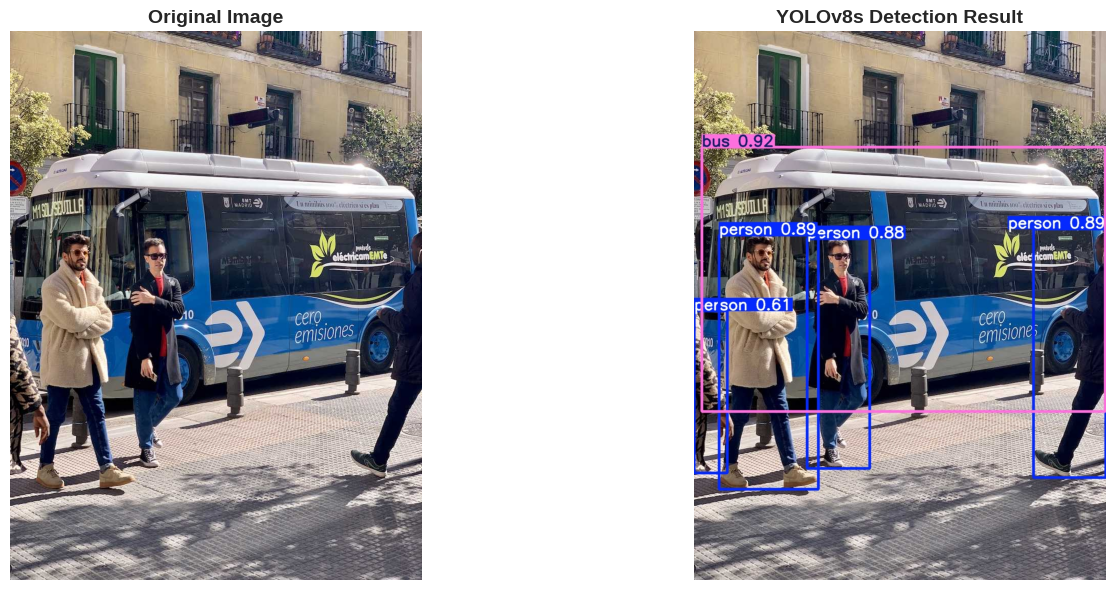


결과 저장: pretrained_result.png


In [14]:
# 결과 이미지 시각화
result_path = 'runs/detect/pretrained_test/sample.jpg'
if os.path.exists(result_path):
    result_img = Image.open(result_path)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 원본 이미지
    axes[0].imshow(sample_img)
    axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # 검출 결과
    axes[1].imshow(result_img)
    axes[1].set_title('YOLOv8s Detection Result', fontsize=14, fontweight='bold')
    axes[1].axis('off')

    plt.tight_layout()
    plt.savefig('pretrained_result.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n결과 저장: pretrained_result.png")

In [15]:
# Kaggle API 설치 및 설정
print("=== Kaggle API 설정 ===")

# 1. kaggle 패키지 설치
!pip install -q kaggle

import os
from pathlib import Path

# 2. Kaggle API 토큰 설정 방법 안내
print("""
Kaggle API 설정 방법:
1. https://www.kaggle.com 에서 로그인
2. 우측 상단 프로필 클릭 → Account
3. 'API' 섹션에서 'Create New API Token' 클릭
4. kaggle.json 파일이 다운로드됨
5. 아래 파일 업로드 버튼으로 kaggle.json 업로드
""")

# Google Colab 파일 업로드
from google.colab import files
import json

print("\n kaggle.json 파일을 업로드하세요:")
uploaded = files.upload()

# kaggle.json 처리
if 'kaggle.json' in uploaded:
    # .kaggle 디렉토리 생성
    kaggle_dir = Path.home() / '.kaggle'
    kaggle_dir.mkdir(exist_ok=True)

    # kaggle.json 저장
    kaggle_path = kaggle_dir / 'kaggle.json'
    with open(kaggle_path, 'w') as f:
        f.write(uploaded['kaggle.json'].decode('utf-8'))

    # 권한 설정 (보안)
    os.chmod(kaggle_path, 0o600)

    print(" Kaggle API 설정 완료!")
else:
    print(" kaggle.json 파일이 업로드되지 않았습니다.")

=== Kaggle API 설정 ===

Kaggle API 설정 방법:
1. https://www.kaggle.com 에서 로그인
2. 우측 상단 프로필 클릭 → Account
3. 'API' 섹션에서 'Create New API Token' 클릭
4. kaggle.json 파일이 다운로드됨
5. 아래 파일 업로드 버튼으로 kaggle.json 업로드


 kaggle.json 파일을 업로드하세요:


Saving kaggle.json to kaggle.json
 Kaggle API 설정 완료!


In [16]:
# Kaggle의 인기 Safety Helmet 데이터셋들

# 여러 데이터셋 옵션 제공
datasets = {
    "1": {
        "name": "Safety Helmet Detection",
        "path": "andrewmvd/hard-hat-detection",
        "desc": "건설 현장 안전모 검출 (YOLO 형식)"
    },
    "2": {
        "name": "Construction Site Safety",
        "path": "snehilsanyal/construction-site-safety-image-dataset-roboflow",
        "desc": "건설 안전 장비 검출 데이터셋"
    },
    "3": {
        "name": "Helmet Detection",
        "path": "vodan37/yolo-helmethead",
        "desc": "YOLO 형식 헬멧 검출 데이터셋"
    },
    "4": {
        "name": "Safety Equipment Detection",
        "path": "muhammetzahitaydin/hardhat-vest-dataset-v4",
        "desc": "안전모와 조끼 검출"
    }
}

# 데이터셋 선택
print("\n사용 가능한 데이터셋:")
for key, dataset in datasets.items():
    print(f"{key}. {dataset['name']}")
    print(f"   - {dataset['desc']}")
    print(f"   - kaggle datasets download -d {dataset['path']}")
    print()

# 사용자 선택 또는 자동 다운로드
choice = input("다운로드할 데이터셋 번호를 선택하세요 (1-4, 기본값: 1): ").strip() or "1"

if choice in datasets:
    selected = datasets[choice]
    print(f"\n선택된 데이터셋: {selected['name']}")

    # Kaggle CLI로 다운로드
    dataset_path = selected['path']
    !kaggle datasets download -d {dataset_path} --unzip -p /content/kaggle_dataset


사용 가능한 데이터셋:
1. Safety Helmet Detection
   - 건설 현장 안전모 검출 (YOLO 형식)
   - kaggle datasets download -d andrewmvd/hard-hat-detection

2. Construction Site Safety
   - 건설 안전 장비 검출 데이터셋
   - kaggle datasets download -d snehilsanyal/construction-site-safety-image-dataset-roboflow

3. Helmet Detection
   - YOLO 형식 헬멧 검출 데이터셋
   - kaggle datasets download -d vodan37/yolo-helmethead

4. Safety Equipment Detection
   - 안전모와 조끼 검출
   - kaggle datasets download -d muhammetzahitaydin/hardhat-vest-dataset-v4

다운로드할 데이터셋 번호를 선택하세요 (1-4, 기본값: 1): 1

선택된 데이터셋: Safety Helmet Detection
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/hard-hat-detection
License(s): CC0-1.0
 92% 1.12G/1.22G [00:00<00:00, 1.63GB/s]
100% 1.22G/1.22G [00:00<00:00, 1.57GB/s]


In [17]:
# YOLOv8 형식으로 데이터 구조 정리
import os
import shutil
from pathlib import Path
import yaml

print("\n=== YOLOv8 형식으로 데이터셋 변환 ===")

# 데이터셋 경로 탐색
dataset_root = Path('/content/kaggle_dataset')

# 하위 디렉토리 확인
print("다운로드된 파일 구조:")
for item in dataset_root.iterdir():
    if item.is_dir():
        print(f"  {item.name}")
        # 하위 파일 몇 개만 표시
        sub_items = list(item.iterdir())[:5]
        for sub_item in sub_items:
            print(f"    - {sub_item.name}")
    else:
        print(f"  📄 {item.name}")

# YOLOv8 형식으로 재구성
yolo_dataset_path = Path('/content/helmet_yolov8')
yolo_dataset_path.mkdir(exist_ok=True)

# 이미지와 라벨 폴더 생성
for split in ['train', 'val', 'test']:
    (yolo_dataset_path / 'images' / split).mkdir(parents=True, exist_ok=True)
    (yolo_dataset_path / 'labels' / split).mkdir(parents=True, exist_ok=True)

print("\n YOLOv8 디렉토리 구조 생성 완료")

# data.yaml 파일 생성
data_yaml = {
    'path': '/content/helmet_yolov8',
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'nc': 2,  # 클래스 수 (helmet, no-helmet)
    'names': ['helmet', 'no-helmet']  # 또는 ['hardhat', 'no-hardhat', 'person']
}

yaml_path = yolo_dataset_path / 'data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print(f" data.yaml 생성: {yaml_path}")


=== YOLOv8 형식으로 데이터셋 변환 ===
다운로드된 파일 구조:
  annotations
    - hard_hat_workers4235.xml
    - hard_hat_workers172.xml
    - hard_hat_workers2467.xml
    - hard_hat_workers2613.xml
    - hard_hat_workers4667.xml
  images
    - hard_hat_workers3830.png
    - hard_hat_workers4974.png
    - hard_hat_workers3072.png
    - hard_hat_workers2379.png
    - hard_hat_workers4959.png

 YOLOv8 디렉토리 구조 생성 완료
 data.yaml 생성: /content/helmet_yolov8/data.yaml


In [18]:
import xml.etree.ElementTree as ET
import os
from pathlib import Path
import shutil
import random
from tqdm import tqdm

print("=== XML → YOLO 형식 변환 시작 ===")

# 경로 설정
source_images = Path('/content/kaggle_dataset/images')
source_annotations = Path('/content/kaggle_dataset/annotations')
target_dataset = Path('/content/helmet_yolov8')

# 클래스 매핑 (XML의 클래스명 확인 필요)
class_names = ['helmet', 'head', 'person']  # XML 파일에 있는 실제 클래스명으로 수정

def xml_to_yolo(xml_file, img_width, img_height):
    """XML 형식을 YOLO 형식으로 변환"""
    tree = ET.parse(xml_file)
    root = tree.getroot()

    yolo_annotations = []

    for obj in root.findall('object'):
        class_name = obj.find('name').text.lower()

        # 클래스 인덱스 찾기
        if class_name in class_names:
            class_idx = class_names.index(class_name)
        else:
            # 새로운 클래스 발견 시 추가
            if class_name not in class_names:
                class_names.append(class_name)
            class_idx = class_names.index(class_name)

        # 바운딩 박스 좌표 가져오기
        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text) # xml >> txt
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)

        # YOLO 형식으로 변환 (정규화)
        x_center = (xmin + xmax) / 2.0 / img_width
        y_center = (ymin + ymax) / 2.0 / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height

        # YOLO 형식: class_id x_center y_center width height
        yolo_annotations.append(f"{class_idx} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    return yolo_annotations

# XML 파일에서 실제 클래스명 추출
print("\n클래스 탐색 중...")
actual_classes = set()
for xml_file in source_annotations.glob('*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for obj in root.findall('object'):
        actual_classes.add(obj.find('name').text.lower())

class_names = sorted(list(actual_classes))
print(f"발견된 클래스: {class_names}")
print(f"클래스 수: {len(class_names)}")

=== XML → YOLO 형식 변환 시작 ===

클래스 탐색 중...
발견된 클래스: ['head', 'helmet', 'person']
클래스 수: 3


In [19]:
from PIL import Image
import cv2

print("\n=== 이미지-라벨 매칭 및 변환 ===")

# 모든 이미지 파일 목록
all_images = list(source_images.glob('*.png')) + list(source_images.glob('*.jpg'))
print(f"총 이미지 수: {len(all_images)}")

# 이미지-XML 쌍 매칭
matched_data = []
unmatched_images = []

for img_path in all_images:
    # 대응하는 XML 파일 찾기
    # 이미지 파일 이름에서 뒤에 꼬리표(.png) 떼어서 .xml 붙여가 찾아봄
    xml_name = img_path.stem + '.xml'
    xml_path = source_annotations / xml_name

    if xml_path.exists():
        matched_data.append((img_path, xml_path))
    else:
        unmatched_images.append(img_path)

print(f" 매칭된 이미지-라벨 쌍: {len(matched_data)}")
print(f" 라벨 없는 이미지: {len(unmatched_images)}")

# YOLO 형식으로 변환
print("\nYOLO 형식으로 변환 중...")
converted_data = []

for img_path, xml_path in tqdm(matched_data, desc="변환 진행"):
    try:
        # 이미지 크기 가져오기
        img = Image.open(img_path)
        img_width, img_height = img.size

        # XML을 YOLO로 변환
        yolo_annotations = xml_to_yolo(xml_path, img_width, img_height)

        if yolo_annotations:  # 라벨이 있는 경우만
            converted_data.append({
                'image': img_path,
                'labels': yolo_annotations
            })
    except Exception as e:
        print(f"변환 실패 {img_path.name}: {e}")

print(f"\n 성공적으로 변환된 데이터: {len(converted_data)}")


=== 이미지-라벨 매칭 및 변환 ===
총 이미지 수: 5000
 매칭된 이미지-라벨 쌍: 5000
 라벨 없는 이미지: 0

YOLO 형식으로 변환 중...


변환 진행: 100%|██████████| 5000/5000 [00:00<00:00, 5039.62it/s]


 성공적으로 변환된 데이터: 5000


In [20]:
import random
from sklearn.model_selection import train_test_split

print("\n=== 데이터셋 분할 (Train/Val/Test) ===")

# 데이터 섞기
random.shuffle(converted_data)

# 분할 비율: 70% train, 20% val, 10% test
train_size = int(len(converted_data) * 0.7)
val_size = int(len(converted_data) * 0.2)

train_data = converted_data[:train_size]
val_data = converted_data[train_size:train_size + val_size]
test_data = converted_data[train_size + val_size:]

print(f" 데이터 분할:")
print(f"  • Train: {len(train_data)} 이미지")
print(f"  • Val: {len(val_data)} 이미지")
print(f"  • Test: {len(test_data)} 이미지")

# 파일 복사 함수
def copy_and_save_data(data_list, split_name):
    """이미지 복사 및 라벨 저장"""
    img_dir = target_dataset / 'images' / split_name
    label_dir = target_dataset / 'labels' / split_name

    img_dir.mkdir(parents=True, exist_ok=True)
    label_dir.mkdir(parents=True, exist_ok=True)

    for item in tqdm(data_list, desc=f"{split_name} 처리"):
        # 이미지 복사
        img_path = item['image']
        new_img_path = img_dir / img_path.name
        shutil.copy2(img_path, new_img_path)

        # 라벨 저장
        label_name = img_path.stem + '.txt'
        label_path = label_dir / label_name

        with open(label_path, 'w') as f:
            for line in item['labels']:
                f.write(line + '\n')

# 각 분할에 대해 파일 복사 및 저장
print("\n파일 복사 중...")
copy_and_save_data(train_data, 'train')
copy_and_save_data(val_data, 'val')
copy_and_save_data(test_data, 'test')

print("\n 데이터셋 구성 완료!")


=== 데이터셋 분할 (Train/Val/Test) ===
 데이터 분할:
  • Train: 3500 이미지
  • Val: 1000 이미지
  • Test: 500 이미지

파일 복사 중...


test 처리: 100%|██████████| 500/500 [00:00<00:00, 2377.24it/s]


 데이터셋 구성 완료!


In [21]:
import yaml

print("\n=== data.yaml 파일 업데이트 ===")

# 데이터셋 설정
data_config = {
    'path': '/content/helmet_yolov8',  # 데이터셋 루트 경로
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',

    # 클래스 정보
    'nc': len(class_names),  # 클래스 수
    'names': class_names     # 클래스 이름 리스트
}

# YAML 파일 저장
yaml_path = target_dataset / 'data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f, default_flow_style=False, sort_keys=False)

print(f" data.yaml 업데이트 완료: {yaml_path}")
print(f"\n 클래스 정보:")
for i, name in enumerate(class_names):
    print(f"  {i}: {name}")

# 데이터셋 통계 출력
print("\n 최종 데이터셋 구조:")
for split in ['train', 'val', 'test']:
    img_count = len(list((target_dataset / 'images' / split).glob('*')))
    label_count = len(list((target_dataset / 'labels' / split).glob('*.txt')))
    print(f"  • {split}: {img_count} 이미지, {label_count} 라벨")


=== data.yaml 파일 업데이트 ===
 data.yaml 업데이트 완료: /content/helmet_yolov8/data.yaml

 클래스 정보:
  0: head
  1: helmet
  2: person

 최종 데이터셋 구조:
  • train: 3500 이미지, 3500 라벨
  • val: 1000 이미지, 1000 라벨
  • test: 500 이미지, 500 라벨



=== 데이터셋 검증 및 시각화 ===


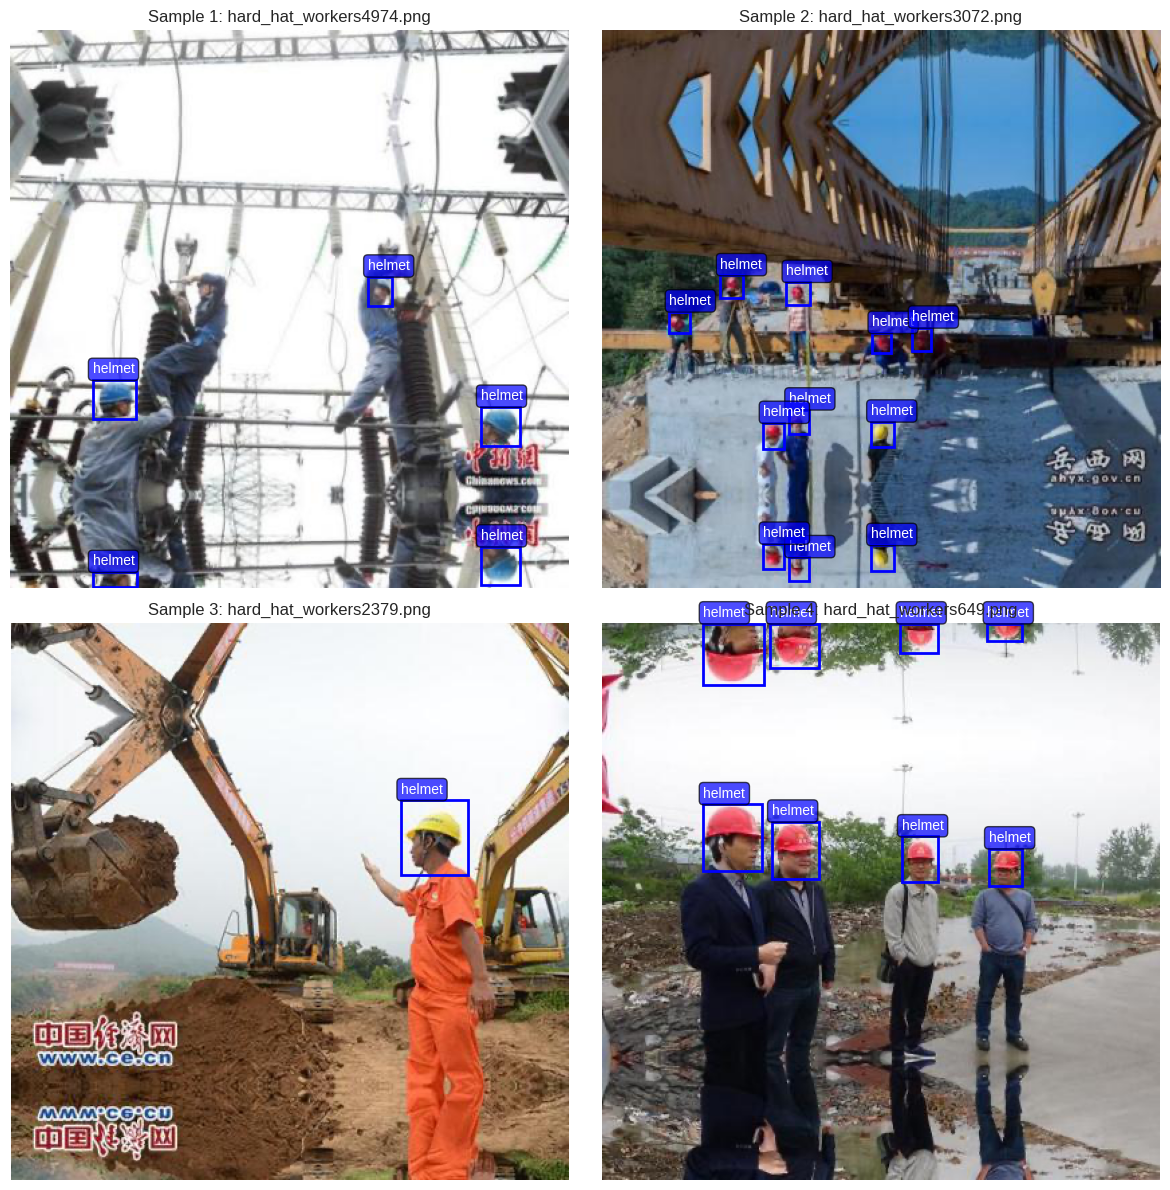

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

print("\n=== 데이터셋 검증 및 시각화 ===")

def visualize_yolo_annotations(image_path, label_path, class_names):
    """YOLO 어노테이션 시각화"""
    # 이미지 로드
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width = img.shape[:2]

    # 라벨 로드
    annotations = []
    if label_path.exists():
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_idx = int(parts[0])
                    x_center = float(parts[1]) * width
                    y_center = float(parts[2]) * height
                    box_width = float(parts[3]) * width
                    box_height = float(parts[4]) * height

                    # 좌상단 좌표 계산
                    x1 = x_center - box_width / 2
                    y1 = y_center - box_height / 2

                    annotations.append({
                        'class': class_idx,
                        'x1': x1, 'y1': y1,
                        'width': box_width, 'height': box_height
                    })

    return img, annotations

# 샘플 시각화
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()

# Train 세트에서 랜덤 샘플 선택
train_images = list((target_dataset / 'images' / 'train').glob('*'))[:4]

colors = ['red', 'blue', 'green', 'yellow', 'cyan', 'magenta']

for idx, img_path in enumerate(train_images):
    label_path = target_dataset / 'labels' / 'train' / (img_path.stem + '.txt')

    img, annotations = visualize_yolo_annotations(img_path, label_path, class_names)

    axes[idx].imshow(img)
    axes[idx].set_title(f"Sample {idx+1}: {img_path.name}")

    # 바운딩 박스 그리기
    for ann in annotations:
        rect = patches.Rectangle(
            (ann['x1'], ann['y1']), ann['width'], ann['height'],
            linewidth=2, edgecolor=colors[ann['class'] % len(colors)],
            facecolor='none'
            # box 내부 색칠하지마(투명하게 둬)
        )
        axes[idx].add_patch(rect)

        # 클래스 이름 표시
        class_name = class_names[ann['class']]
        axes[idx].text(ann['x1'], ann['y1']-5, class_name,
                      color='white', fontsize=10,
                      bbox=dict(boxstyle='round', facecolor=colors[ann['class'] % len(colors)], alpha=0.7))

    axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [23]:
from ultralytics import YOLO

# 모델 초기화
model = YOLO('yolov8n.pt') # nano model(빠른 학습)

# 학습 시작

results = model.train(
    data= '/content/helmet_yolov8/data.yaml',   # 데이터 설정 파일
    epochs=10,
    imgsz=640,                                  # 이미지 크기
    batch=128,
    name='helmet_detection',
    patience=10,                                # 조기종료
    save=True,                                  # 모델 저장
    device='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=True,                               # 학습 진행과정 출력 여부 결정
    # ----- 추가 가능한 옵션 예시 -----
    lr0=0.01,                                   # 초기 학습률
    weight_decay=0.0005,                        # 가중치 감소 (L2 정규화)
    fliplr=0.2,                                 # 좌우 반전 확률
    optimizer='AdamW',                          # 옵티마이저 선택 (e.g., 'SGD', 'Adam', 'AdamW')
    mosaic=0.2,                               # 모자이크 증강 확률
    degrees=10.0,                             # 이미지 회전 각도
    # -----------------------------------
)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=128, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/helmet_yolov8/data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.2, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.2, multi_scale=False, name=helmet_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=10, perspect

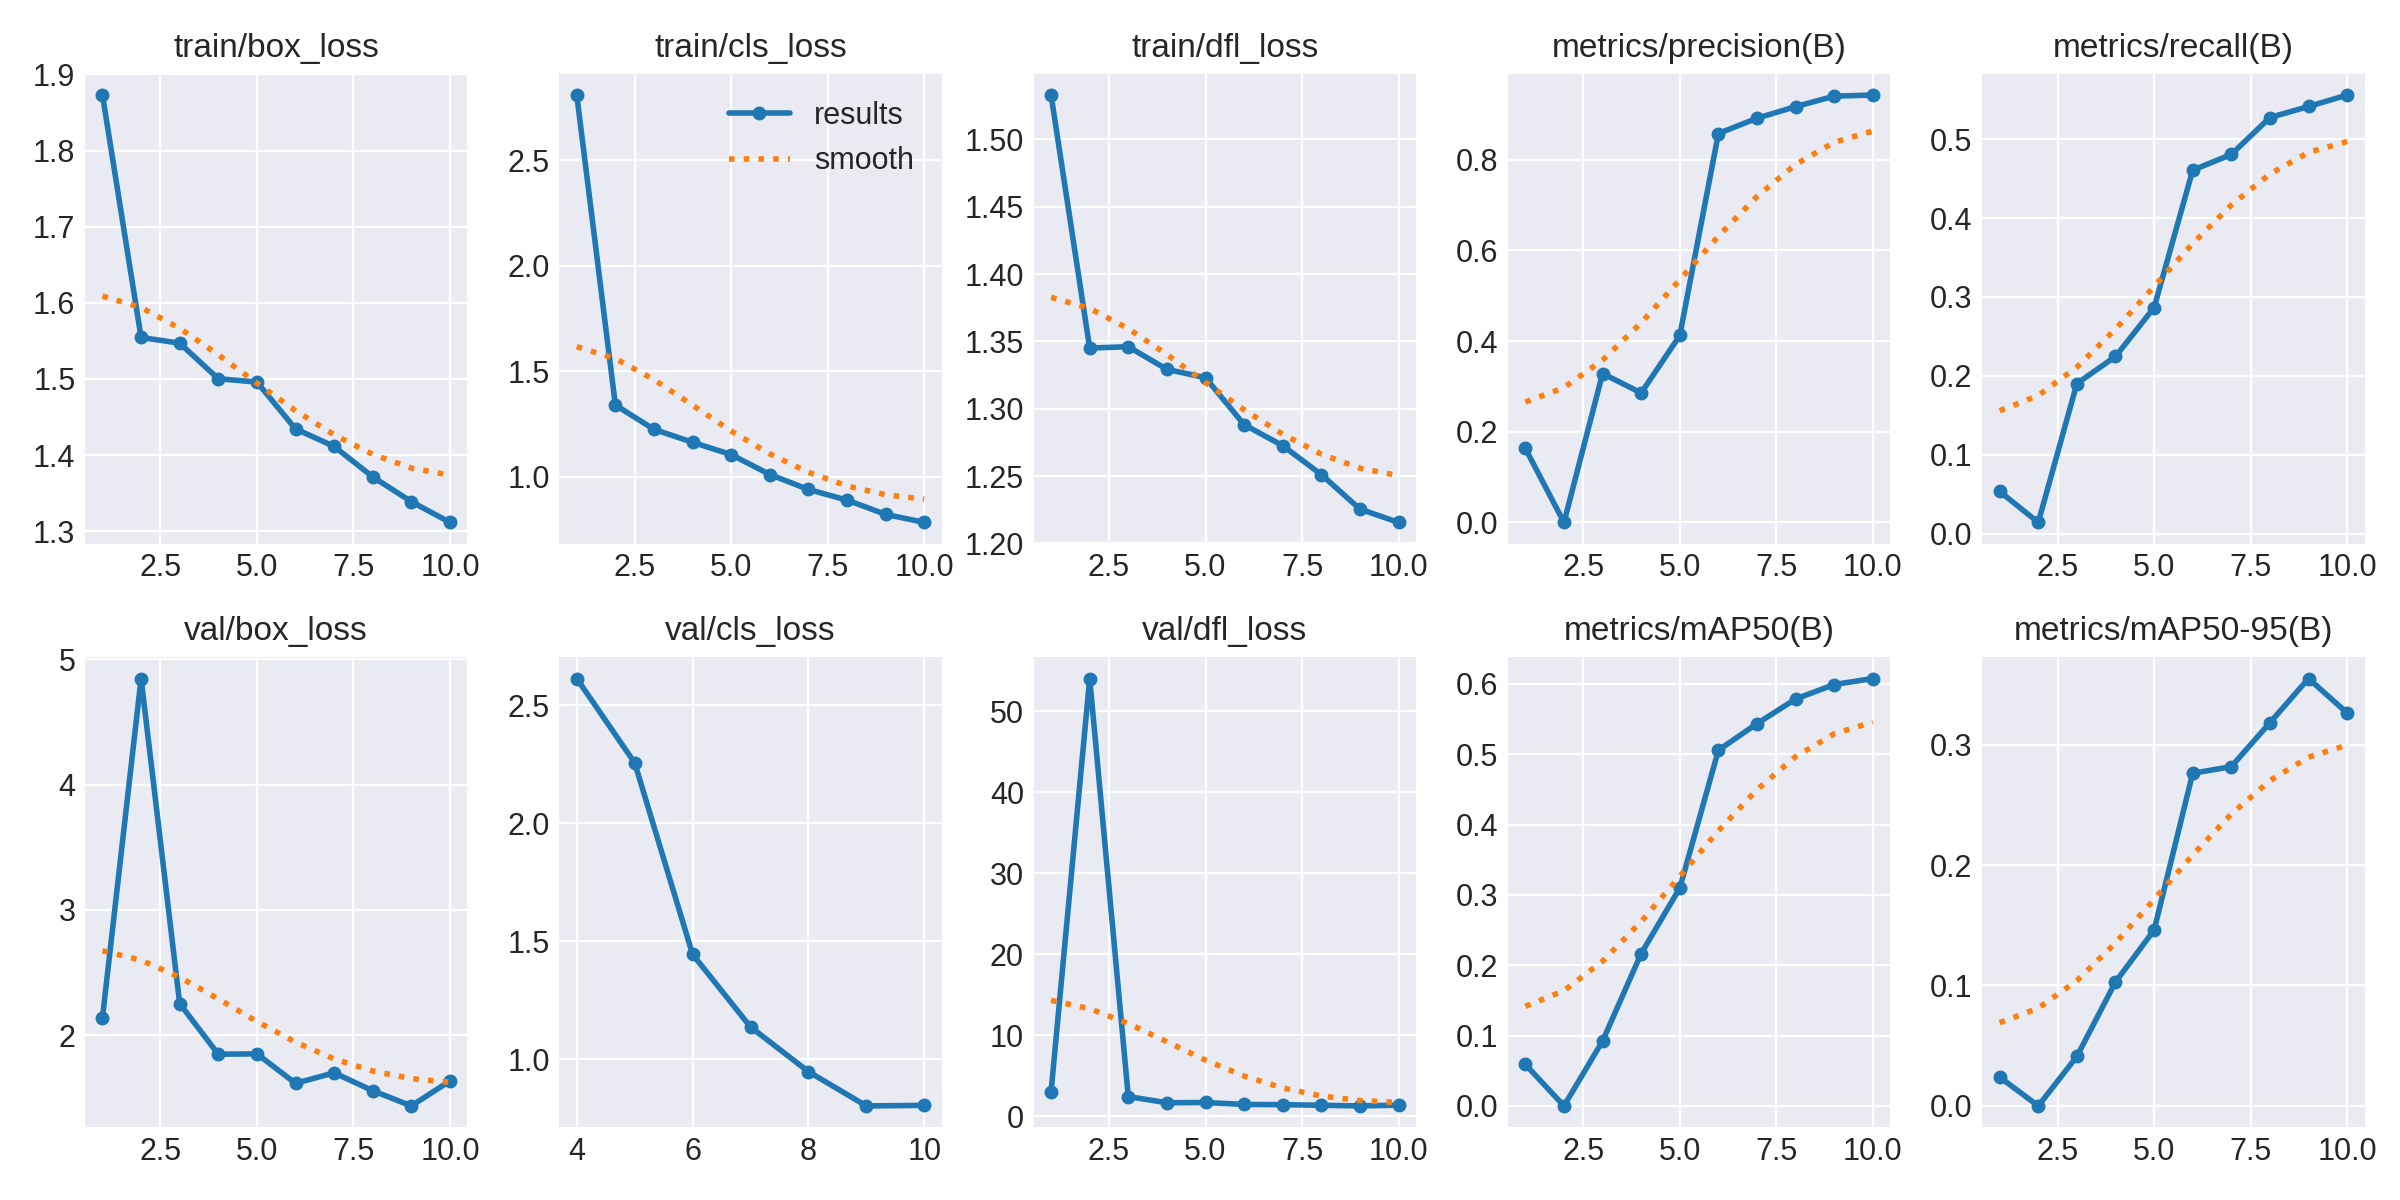

In [24]:
# 학습 결과 시각화
from IPython.display import Image, display
results_path = Path('runs/detect/helmet_detection')
if (results_path / 'results.png').exists():
    display(Image(filename=str(results_path / 'results.png')))

In [25]:
# =================================================================
# 1. 전역 변수 및 라이브러리 설정 (경로 고정)
# =================================================================
import os
import torch
import yaml
from pathlib import Path
from PIL import Image
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from IPython.display import display
from typing import Dict, Any

# -----------------------------------------------------------
# 경로 고정: 사용자가 제시한 경로를 기준으로 설정합니다.
# -----------------------------------------------------------

# 데이터셋의 기본 경로 (data.yaml이 위치한 디렉토리)
dataset_base_dir = Path('/content/helmet_yolov8')
yaml_path = str(dataset_base_dir / 'data.yaml')

# 최종 학습 결과 경로
train_dir_name = 'helmet_detection'
train_dir = Path('runs/detect') / train_dir_name
best_model_path = train_dir / 'weights' / 'best.pt'

device = 'cuda' if torch.cuda.is_available() else 'cpu'


# data.yaml 로드 및 클래스 이름 정의
data_config: Dict[str, Any] = {}
try:
    with open(yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)
    class_names = data_config.get('names', {})
    if isinstance(class_names, list):
         class_names = {i: name for i, name in enumerate(class_names)}
except Exception:
    # data.yaml 로드 실패 시 임시 정의 (추론 시 NameError 방지)
    class_names = {0: 'helmet', 1: 'person', 2: 'no-helmet'}
    print(f"[경고] data.yaml 로드 실패. 임시 클래스 이름을 사용합니다: {list(class_names.values())}")

# =================================================================

print(f"모델 경로: {best_model_path}")
print(f"클래스 목록: {list(class_names.values())}")
print(f"데이터셋 BASE 경로: {dataset_base_dir}")

모델 경로: runs/detect/helmet_detection/weights/best.pt
클래스 목록: ['head', 'helmet', 'person']
데이터셋 BASE 경로: /content/helmet_yolov8


In [26]:
# =================================================================
# 2. 학습된 모델 테스트 및 추론 시각화
# =================================================================

print("\n=== 학습된 모델 테스트 ===")

if best_model_path.exists():
    # 최고 성능 모델 로드
    model = YOLO(str(best_model_path))

    # 테스트 이미지 경로 설정 (가장 흔한 YOLO 형식: {dataset_path}/images/test 또는 {dataset_path}/test/images)
    test_images_dir_option1 = dataset_base_dir / 'images' / 'test'
    test_images_dir_option2 = dataset_base_dir / 'test' / 'images'

    test_images_dir = None
    if test_images_dir_option1.exists():
        test_images_dir = test_images_dir_option1
    elif test_images_dir_option2.exists():
        test_images_dir = test_images_dir_option2


    if test_images_dir and test_images_dir.exists():
        test_images = list(test_images_dir.glob('*'))[:3]

        for img_path in test_images:
            # 추론
            results = model(str(img_path), conf=0.25, iou=0.45, device=device)

            # 결과 저장 및 출력
            for r in results:
                # r.plot()은 BGR 형식의 numpy array 반환
                im_array = r.plot()

                # BGR을 RGB로 변환 후, Image.fromarray로 PIL 이미지 생성
                im = Image.fromarray(im_array[..., ::-1])

                # /content/에 결과 저장
                output_path = Path(f'/content/test_result_{img_path.name}')
                im.save(output_path)
                print(f" 결과 저장: {output_path}")

                # 검출 정보 출력
                if r.boxes is not None:
                    print(f" 검출 객체 수: {len(r.boxes)}")
                    for box in r.boxes:
                        # YOLOv8 결과는 텐서이므로 .item()으로 스칼라 값 추출
                        cls_id = int(box.cls.item())
                        conf = float(box.conf.item())

                        # class_names 변수 사용
                        class_name = class_names.get(cls_id, f'Unknown Class {cls_id}')
                        print(f"  - {class_name}: {conf:.2%}")

        print("\n 추론 과정이 완료되었습니다!")
    else:
        print(f"\n[경고] 학습된 모델 파일은 존재하나, 테스트 이미지를 찾을 수 없습니다. 경로를 확인하세요.")
else:
    print(f"\n[경고] 학습된 모델 파일({best_model_path})을 찾을 수 없어 추론을 건너뜁니다.")


=== 학습된 모델 테스트 ===

image 1/1 /content/helmet_yolov8/images/test/hard_hat_workers3586.png: 640x640 8 heads, 6.5ms
Speed: 3.1ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
 결과 저장: /content/test_result_hard_hat_workers3586.png
 검출 객체 수: 8
  - head: 86.52%
  - head: 84.02%
  - head: 83.62%
  - head: 81.06%
  - head: 73.51%
  - head: 71.97%
  - head: 70.35%
  - head: 41.44%

image 1/1 /content/helmet_yolov8/images/test/hard_hat_workers149.png: 640x640 8 heads, 7.3ms
Speed: 2.5ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
 결과 저장: /content/test_result_hard_hat_workers149.png
 검출 객체 수: 8
  - head: 75.43%
  - head: 73.56%
  - head: 72.17%
  - head: 68.54%
  - head: 67.60%
  - head: 66.99%
  - head: 49.80%
  - head: 39.64%

image 1/1 /content/helmet_yolov8/images/test/hard_hat_workers2288.png: 640x640 1 head, 18 helmets, 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640,


=== 모델 평가 및 시각화 ===

Validation 평가 중...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3738.2±976.0 MB/s, size: 260.7 KB)
val: Scanning /content/helmet_yolov8/labels/val.cache... 1000 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1000/1000 1.9Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 63/63 10.1it/s 6.3s
                   all       1000       5019      0.941      0.542      0.599      0.355
                  head        178       1179      0.894      0.815      0.883      0.529
                helmet        917       3698      0.928      0.811      0.904      0.534
                person         26        142          1          0     0.0111    0.00276
Speed: 0.8ms preprocess, 0.9ms inference, 0.0ms loss, 0.9ms postprocess per 

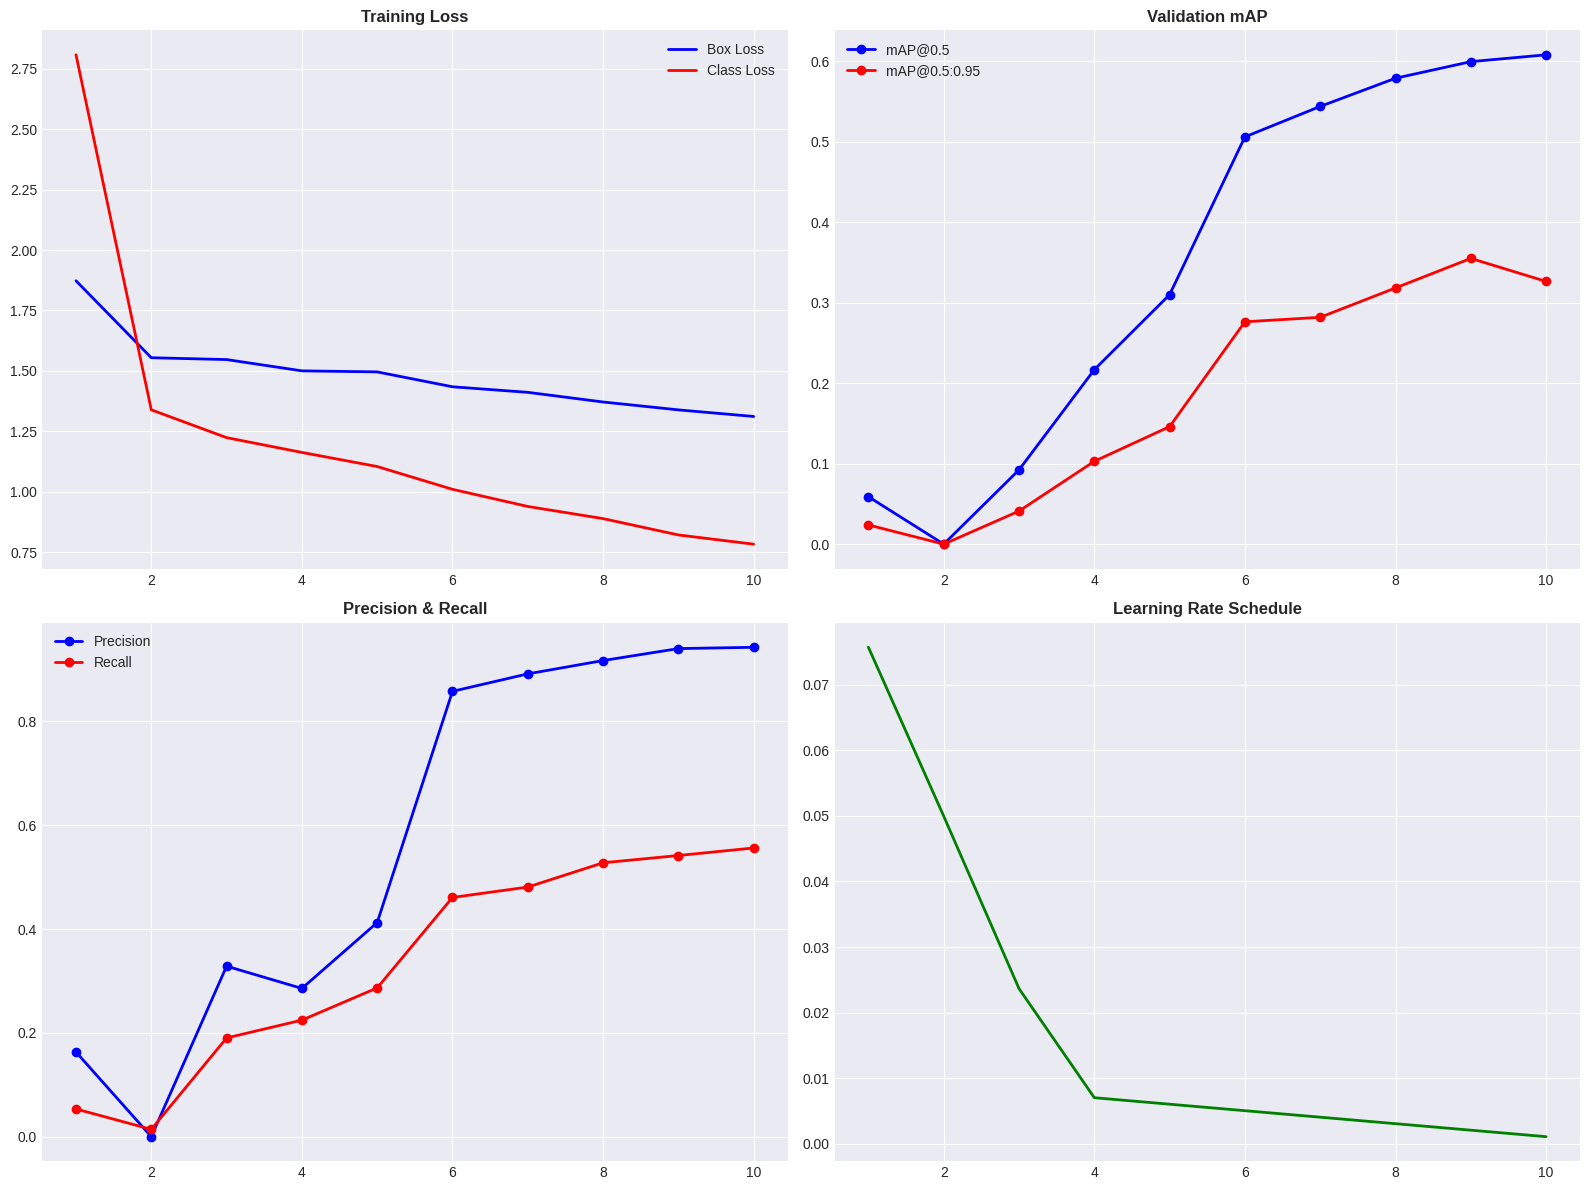

학습 곡선 저장: training_curves_analysis.png

Confusion Matrix:


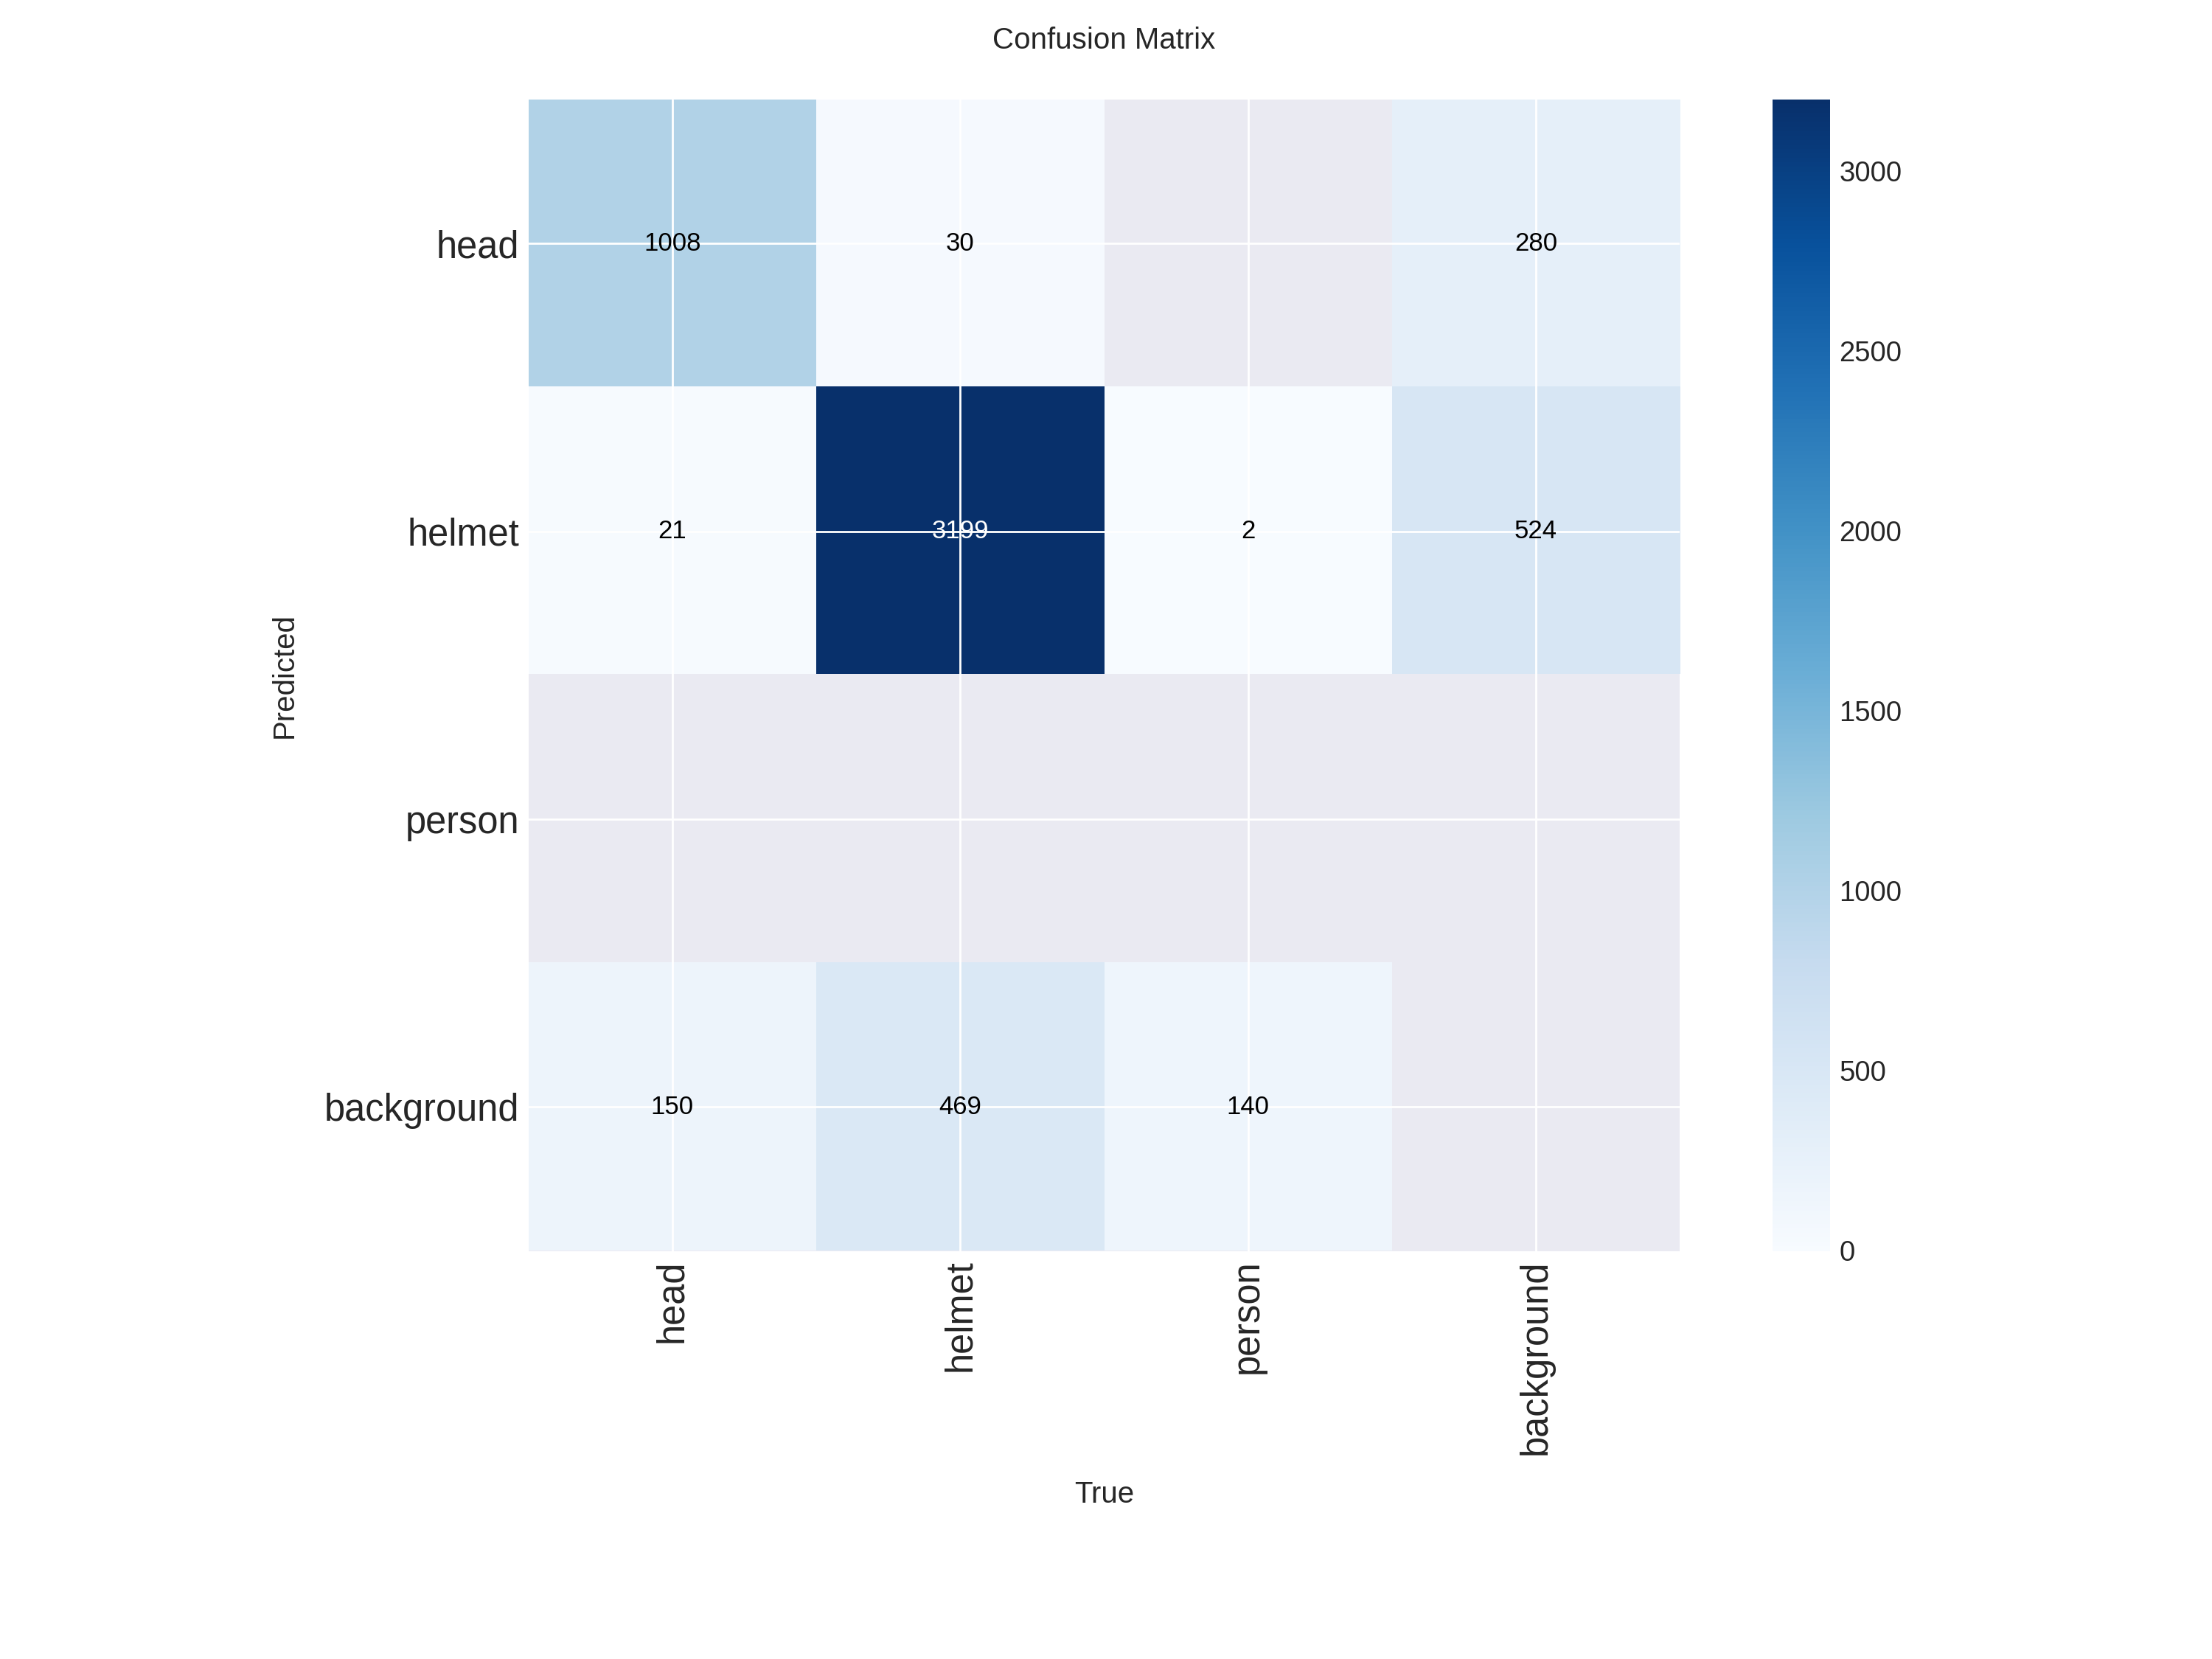

Confusion Matrix 표시 완료


In [27]:
# =================================================================
# 3. 모델 평가 및 결과 시각화 (NameError 해결)
# =================================================================
import os
import torch
import yaml
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO

# NameError 방지: IPython.display를 다시 임포트하고 별칭을 정의합니다.
from IPython.display import display, Image as DisplayImage # Image 객체 재정의


print("\n=== 모델 평가 및 시각화 ===")

# ------------------------------------------------------------------
# [전역 변수 재확인]
# 이 섹션을 실행하기 전에 반드시 다음 변수들이 정의되어 있어야 합니다:
# best_model_path, train_dir, yaml_path, device, class_names
# ------------------------------------------------------------------

# YOLOv8 학습된 모델 로드 (세션에서 model 변수가 사라졌을 경우 재로드)
best_model = YOLO(str(best_model_path)) if best_model_path.exists() else None
train_dir_path = train_dir

if best_model and os.path.exists(yaml_path):

    # 3.1 모델 평가 (Validation)
    print("\nValidation 평가 중...")
    try:
        # data.yaml의 경로를 사용하여 평가 실행
        metrics = best_model.val(
            data=yaml_path,
            imgsz=640,
            batch=16,
            device=device,
            plots=True
        )

        # 평가 결과 출력
        print(f"\n평가 결과:")
        print(f"   mAP@0.5: {metrics.box.map50:.4f}")
        print(f"   mAP@0.5:0.95: {metrics.box.map:.4f}")

    except Exception as e:
        print(f"\n[오류] Validation 평가 중 오류 발생: {e}")


    # 3.2 학습 곡선 및 Confusion Matrix 시각화
    results_csv = train_dir_path / 'results.csv'

    if results_csv.exists():
        print("\n학습 곡선 로드 및 시각화 중...")
        df = pd.read_csv(results_csv)
        df.columns = df.columns.str.strip()

        # 학습 곡선 시각화 (4분할 그래프)
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        if 'train/box_loss' in df.columns and 'metrics/mAP50(B)' in df.columns:
            # Loss 곡선
            axes[0, 0].plot(df['epoch'], df['train/box_loss'], 'b-', label='Box Loss', linewidth=2)
            axes[0, 0].plot(df['epoch'], df['train/cls_loss'], 'r-', label='Class Loss', linewidth=2)
            axes[0, 0].set_title('Training Loss', fontweight='bold'); axes[0, 0].legend()

            # mAP 곡선
            axes[0, 1].plot(df['epoch'], df['metrics/mAP50(B)'], 'b-o', label='mAP@0.5', linewidth=2)
            axes[0, 1].plot(df['epoch'], df['metrics/mAP50-95(B)'], 'r-o', label='mAP@0.5:0.95', linewidth=2)
            axes[0, 1].set_title('Validation mAP', fontweight='bold'); axes[0, 1].legend()

            # Precision & Recall
            axes[1, 0].plot(df['epoch'], df['metrics/precision(B)'], 'b-o', label='Precision', linewidth=2)
            axes[1, 0].plot(df['epoch'], df['metrics/recall(B)'], 'r-o', label='Recall', linewidth=2)
            axes[1, 0].set_title('Precision & Recall', fontweight='bold'); axes[1, 0].legend()

            # Learning Rate
            if 'lr/pg0' in df.columns:
                axes[1, 1].plot(df['epoch'], df['lr/pg0'], 'g-', linewidth=2)
                axes[1, 1].set_title('Learning Rate Schedule', fontweight='bold')

            plt.tight_layout()
            plt.savefig('training_curves_analysis.png', dpi=150, bbox_inches='tight')
            plt.show()
            print("학습 곡선 저장: training_curves_analysis.png")

    # Confusion Matrix (학습 디렉토리에 저장된 이미지 표시)
    cm_path = train_dir_path / 'confusion_matrix.png'
    if cm_path.exists():
        print("\nConfusion Matrix:")
        # DisplayImage 사용
        display(DisplayImage(filename=str(cm_path)))
        print("Confusion Matrix 표시 완료")

    # PR Curve (추가 시각화)
    pr_path = train_dir_path / 'PR_curve.png'
    if pr_path.exists():
        print("\nPrecision-Recall Curve:")
        display(DisplayImage(filename=str(pr_path)))
        print("Precision-Recall Curve 표시 완료")


else:
    print(f"\n[경고] 모델이 로드되지 않았거나 YAML 파일({yaml_path})을 찾을 수 없어 평가를 건너뜁니다.")